In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import h5py
import torch

from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

sys.path.insert(0, '../train/')
from models import TimeSeriesFCN

## Load the data into the required format

In [13]:
# Define the data file to be loaded
file_path = '../data/training/timeseries/training_GW150914_0700_1200_8k.h5'

# Read in the spectrograms from the HDF file
with h5py.File(file_path, 'r') as file:

    x = np.array(file['timeseries'])[:32]
    y = np.array(file['labels'])[:32]

In [14]:
# Swap axes around to get to NCHW format
x = np.swapaxes(x, 1, 3)
x = np.swapaxes(x, 2, 3)
x = np.squeeze(x)

# Convert to torch Tensors
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [15]:
# Create a TensorDataset
tensor_dataset_test = TensorDataset(x, y)

# Create a DataLoader
dataloader_test = DataLoader(tensor_dataset_test, batch_size=4)

## Load the model and set up the net

In [16]:
model = TimeSeriesFCN()

# Load the model weights: A little cumbersome, because we don't have CUDA
# and GPU parallelization like during training time
weights_file = '../train/weights/baseline/timeseries_weights_GW151226_0700_1200_8k.net'
state_dict = torch.load(weights_file, map_location=lambda storage, loc: storage)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)

## Run the model on the test data

In [17]:
# Convert test data to numpy arrays that can be stored in an HDF file
x_test = tensor_dataset_test.data_tensor.cpu().numpy()
y_test = tensor_dataset_test.target_tensor.cpu().numpy()

# Initialize an empty array for our predictions
y_pred = []

# Loop over the test set (in mini-batches) to get the predictions
for mb_idx, mb_data in enumerate(dataloader_test):

    print(mb_idx)
    
    # Calculate the loss for a particular mini-batch
    inputs, labels = mb_data
    inputs = Variable(inputs, volatile=True)
    labels = Variable(labels, volatile=True)

    # Make predictions for the given mini-batch
    outputs = model.forward(inputs)
    outputs = outputs.view((outputs.size()[0], outputs.size()[-1]))
    outputs = outputs.data.cpu().numpy()

    # Stack that onto the previous predictions
    y_pred.append(outputs)

# Convert the list to an np.array (faster than concatenating arrays!)
y_pred = np.vstack(y_pred)

0
1
2
3
4
5
6
7


## Make plots of the predictions

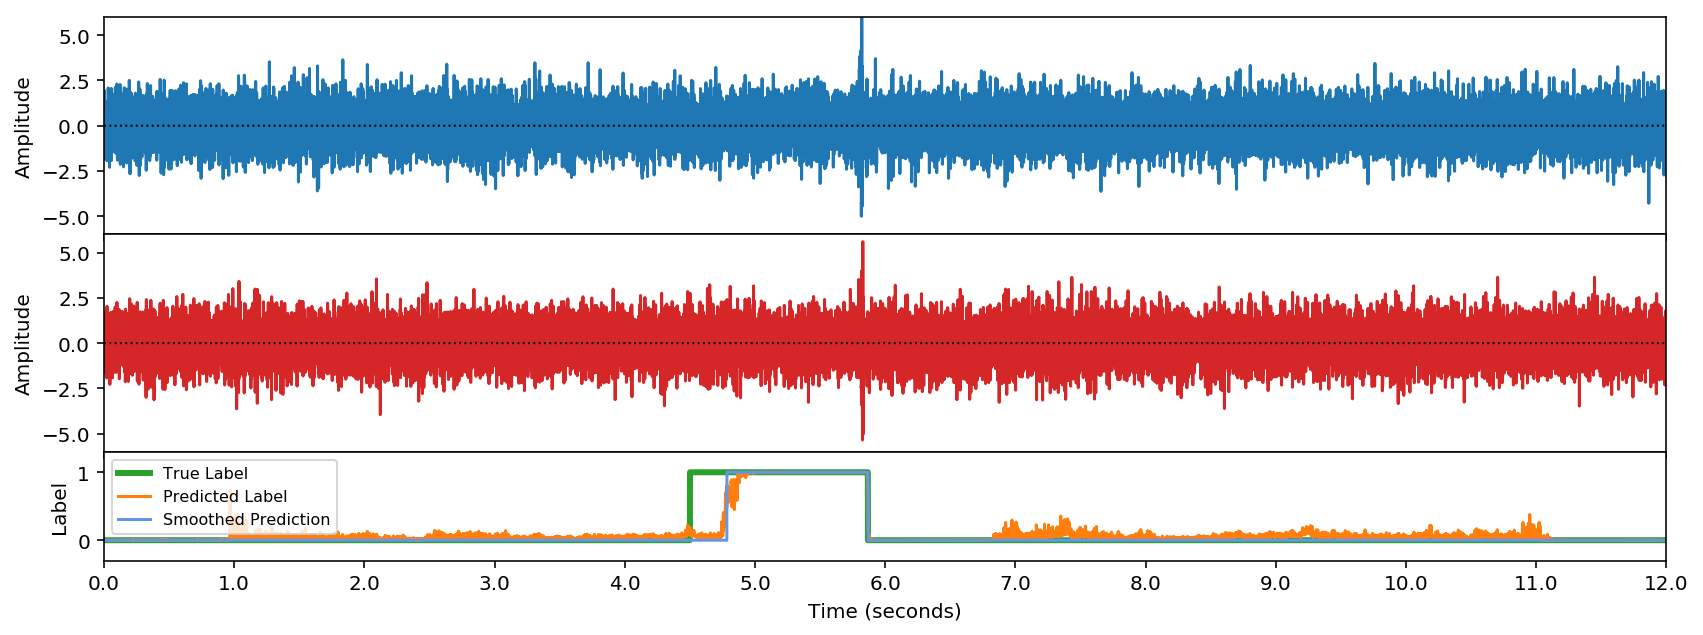

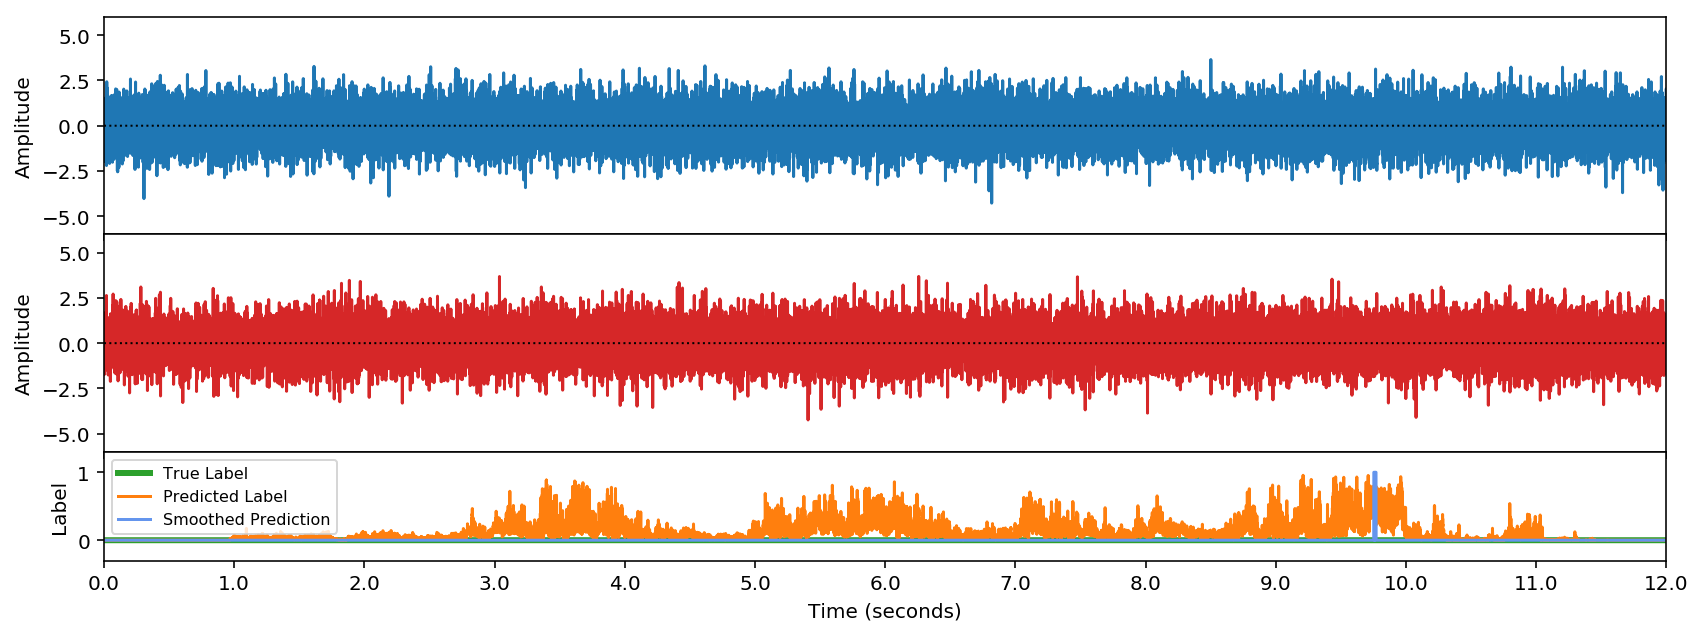

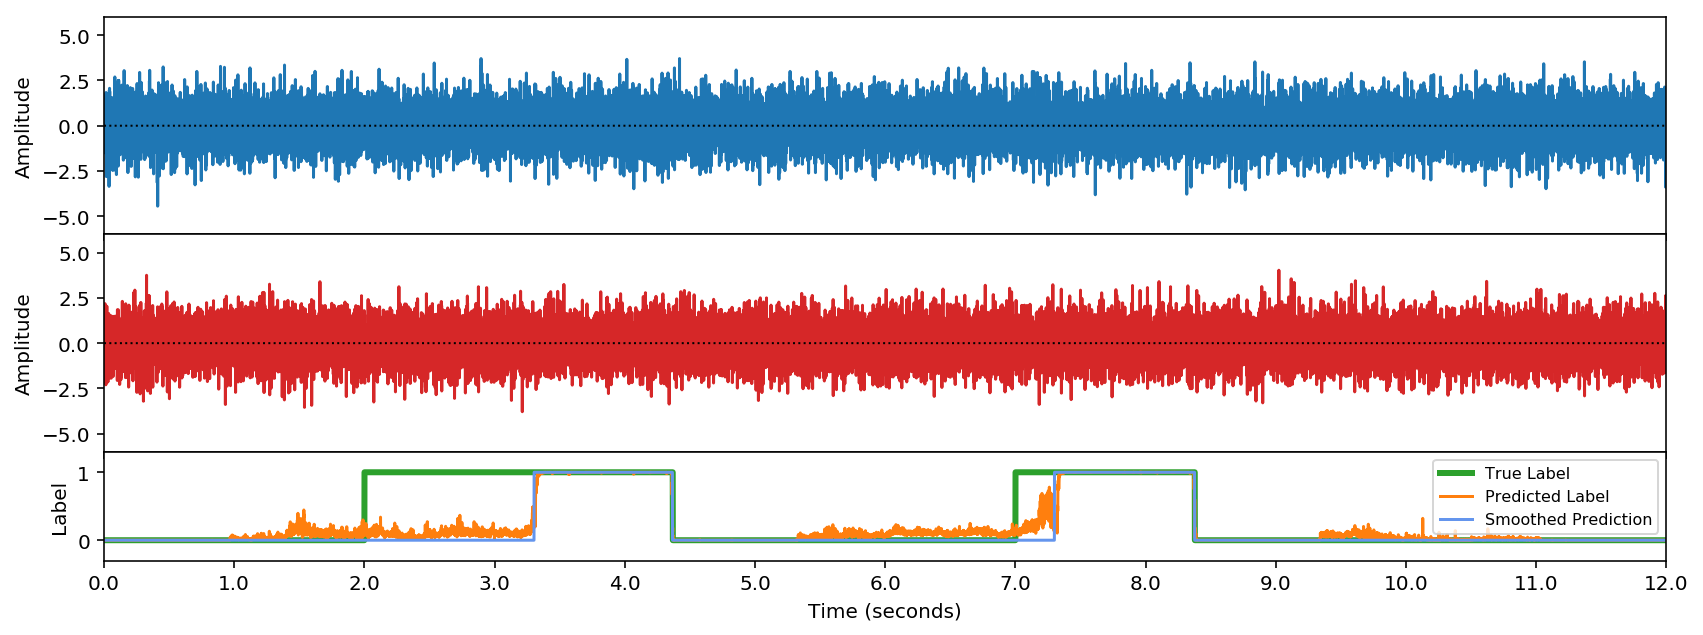

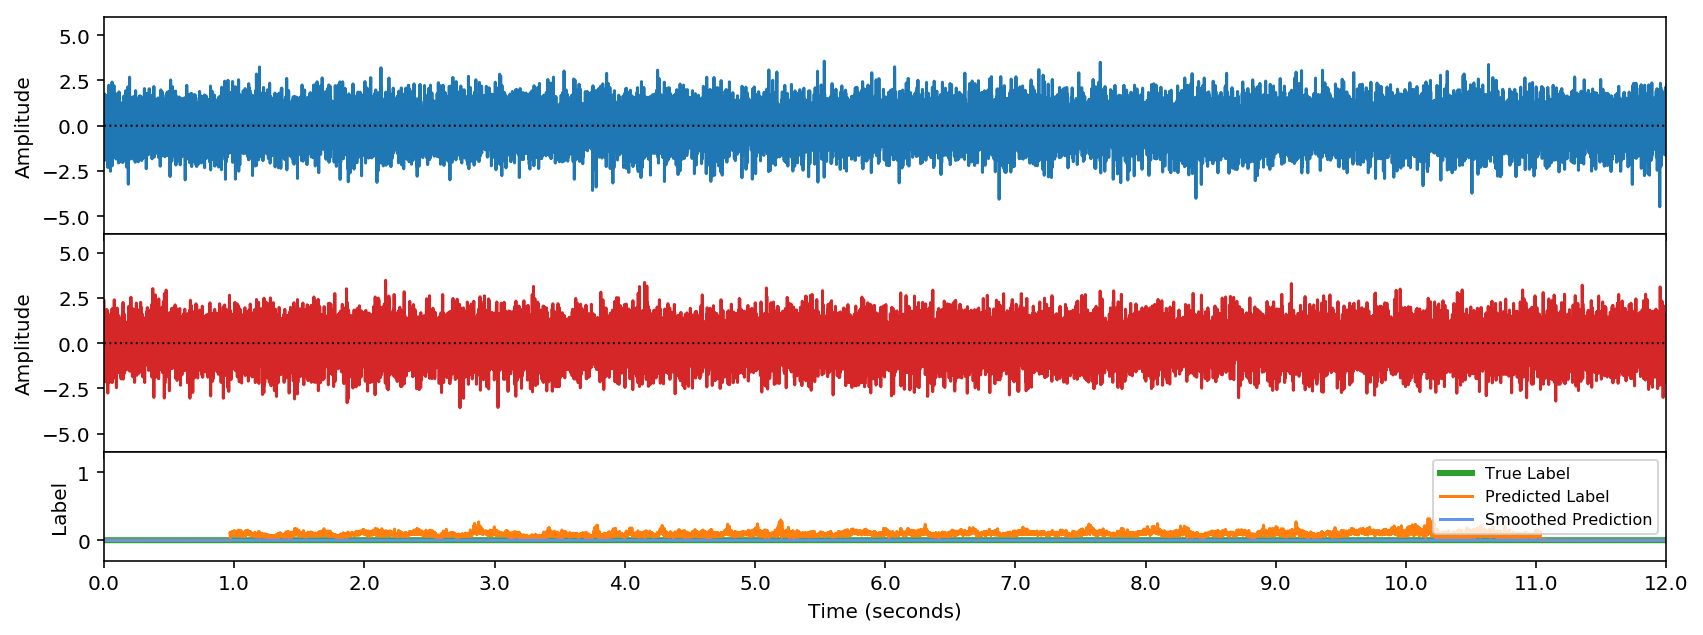

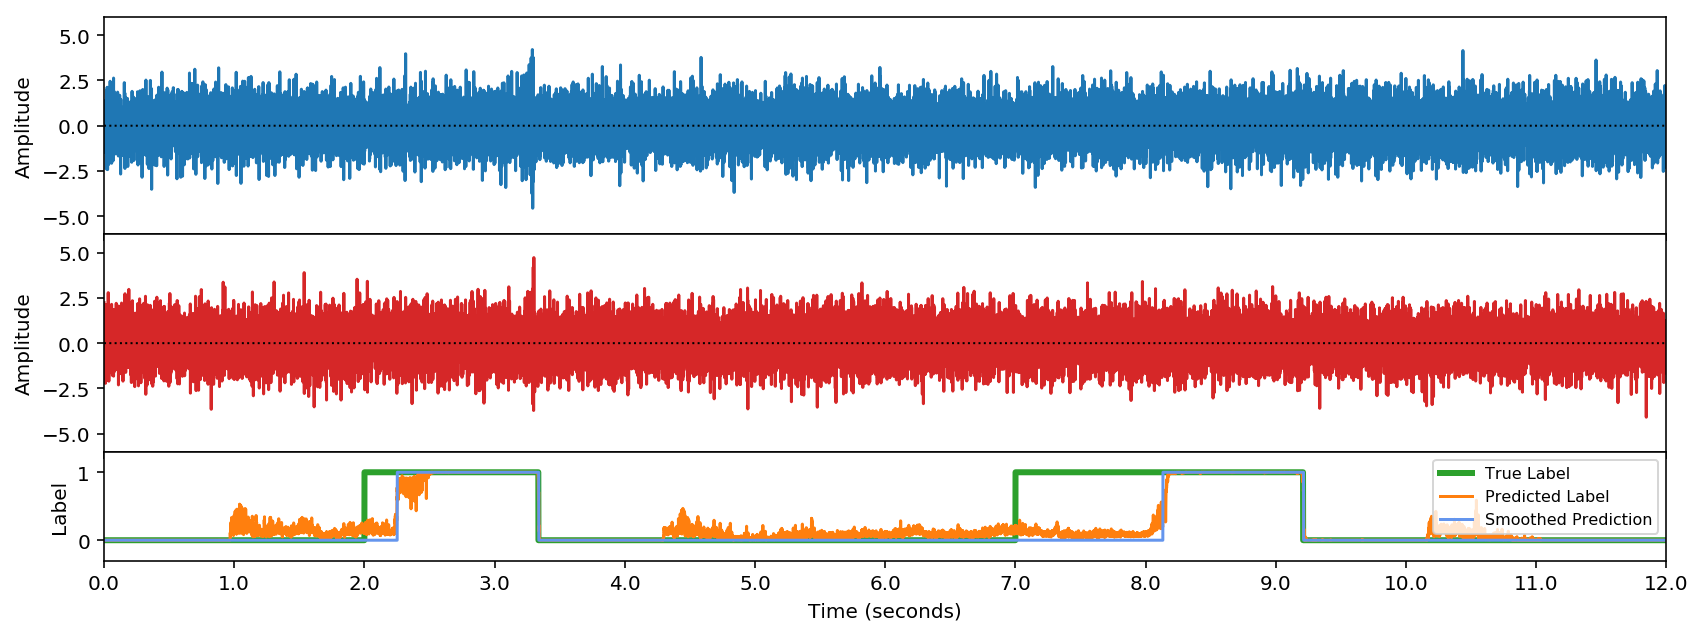

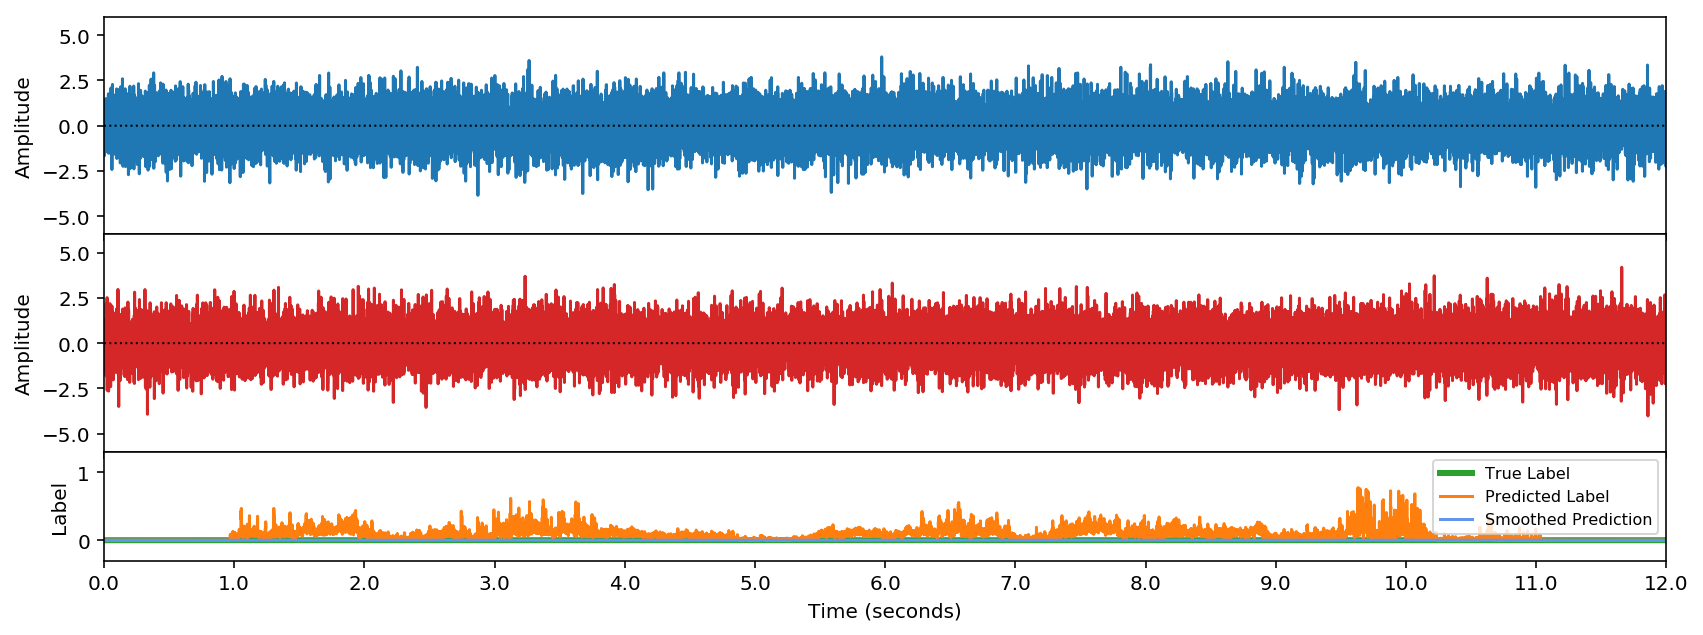

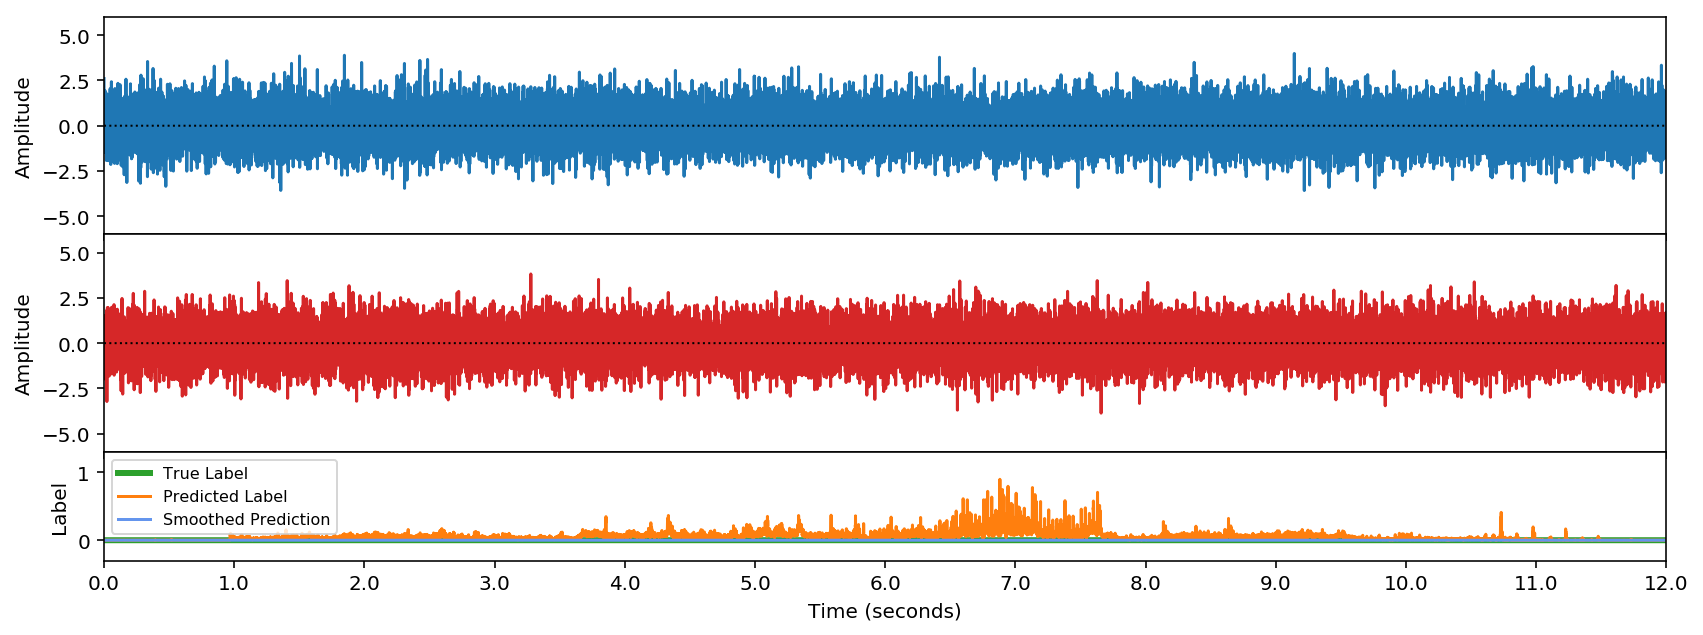

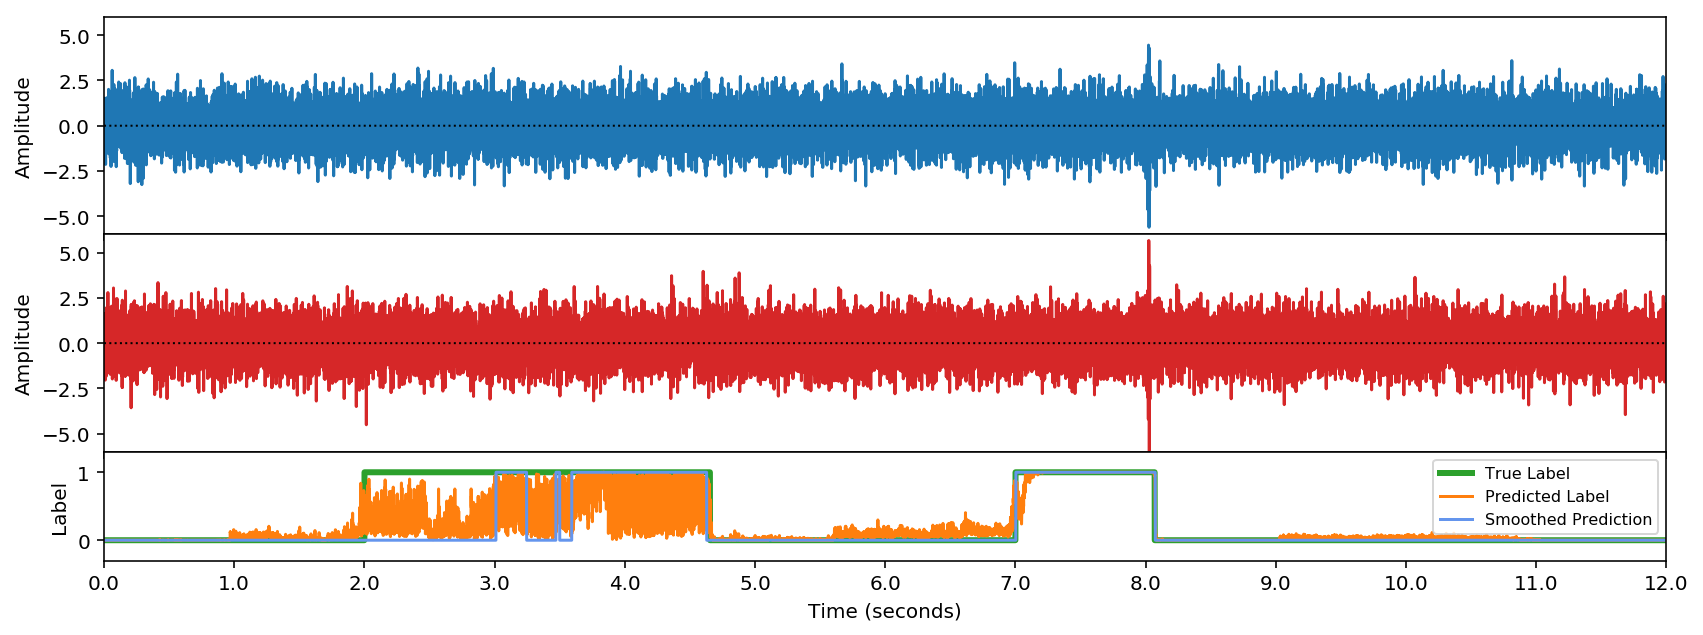

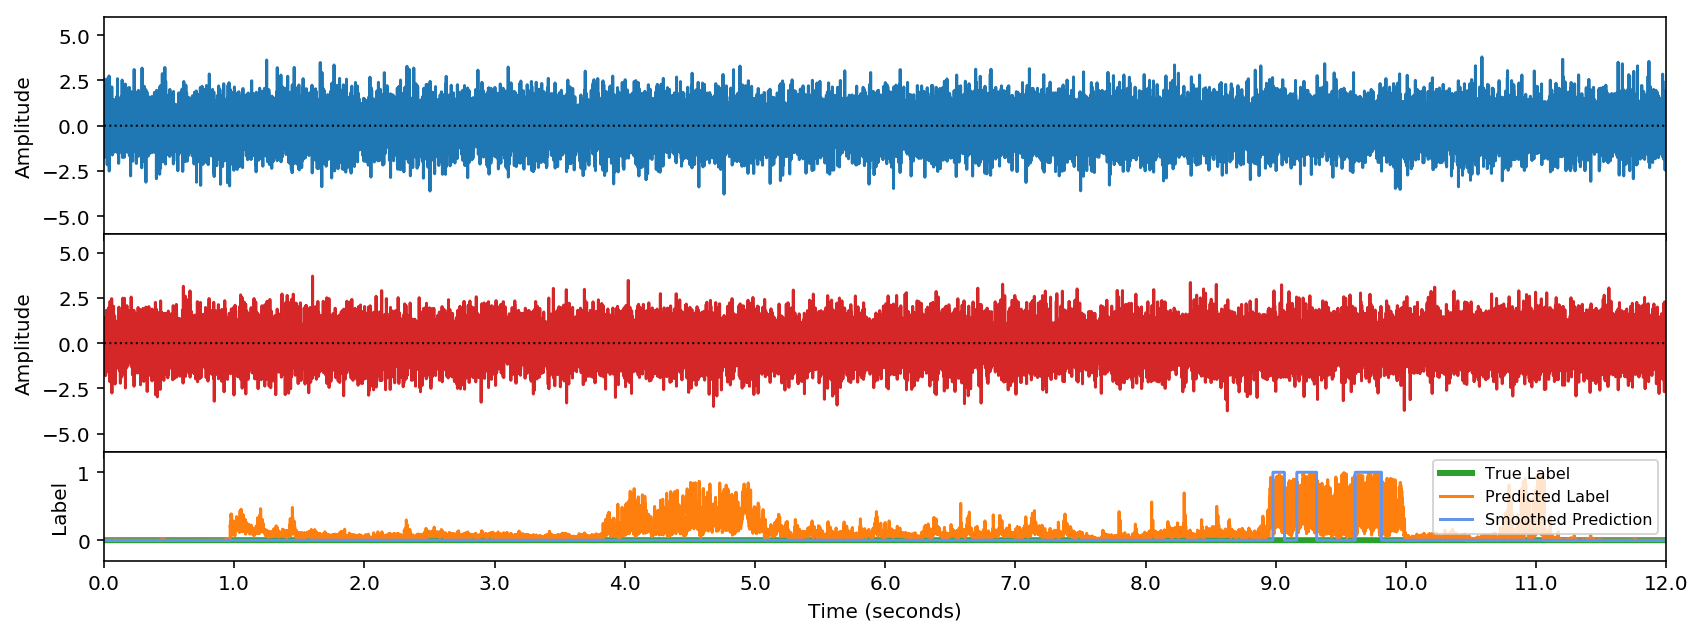

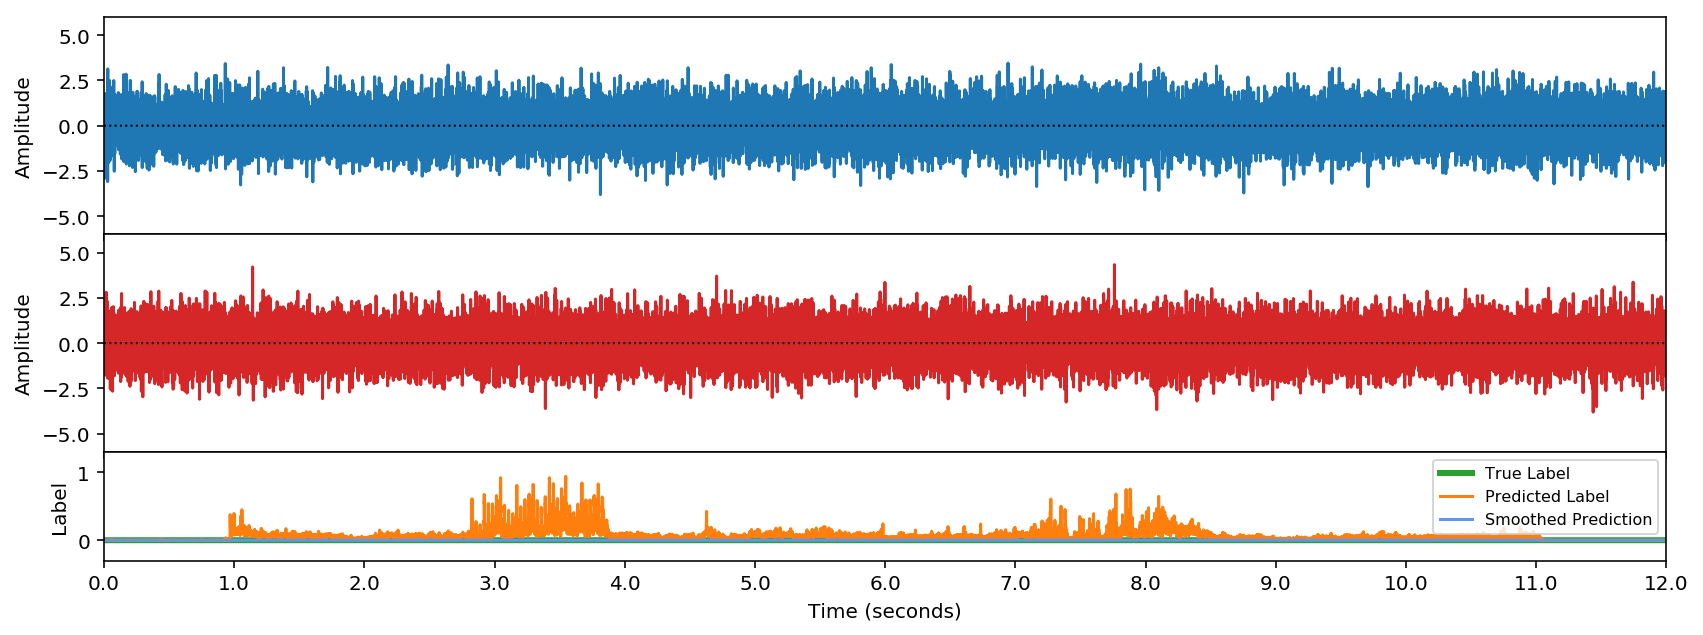

In [18]:
# Plot the first N spectrograms and the respective labels / predictions
for i in range(10, 20):
    
    timeseries_H1 = x_test[i, 0, :]
    timeseries_L1 = x_test[i, 1, :]
    
    grid = np.linspace(0, 12, 12*2048)
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex='col',
                             gridspec_kw={'height_ratios': [4, 4, 2]}, 
                             figsize=(14, 5))
    
    axes[0].plot(grid, timeseries_H1, color='C0')
    axes[0].plot(grid, [0 for _ in grid], color='Black', lw=1, ls=':')
    axes[0].set_ylim(-6, 6)
    axes[0].set_ylabel('Amplitude')
    
    axes[1].plot(grid, timeseries_L1, color='C3')
    axes[1].set_ylim(-6, 6)
    axes[1].plot(grid, [0 for _ in grid], color='Black', lw=1, ls=':')
    axes[1].set_ylabel('Amplitude')
    
    # Calculate and plot the fuzzy-zones
    THRESHOLD = 0  #0.0091125644 * 10e-21
    fuzzy_zones = -1 * np.ones(len(y_pred[i]))
    for j in range(len(y_pred[i])):
        if 0 < y_test[i][j] <= THRESHOLD:
            fuzzy_zones[j] = 1
    axes[2].fill_between(grid, -1, 2*fuzzy_zones, color='Gray', alpha=0.5)
    
    axes[2].plot(grid, np.ceil(y_test[i]), color='C2', lw=3, label='True Label')
    axes[2].plot(grid, y_pred[i], color='C1', lw=1.5, label='Predicted Label')
    
    axes[1].set_xticks([i for i in range(13)[::1]])
    axes[1].set_xticklabels(['{:.1f}'.format(_) for _ in np.linspace(0, 12, 13)[::1]])


    smooth_pred = np.convolve(y_pred[i], np.ones(200), mode='same')/200
    axes[2].plot(grid, np.round(smooth_pred), lw=1.5, color='CornflowerBlue', label='Smoothed Prediction')
    
    axes[2].set_ylim(-0.3, 1.3)
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Label')
    axes[2].legend(loc='best', frameon=True, fontsize=8)
        
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.xlim(0, 12)
    # plt.suptitle('Time Series (H1/L1), True Label and Predicted Label', y=0.95)
    plt.show()